In [1]:
# series and dataframes

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import numpy as np
import pandas as pd
# os 
import os
# graphing
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import os
from google_auth_oauthlib import flow
%load_ext google.cloud.bigquery

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/geoff.parent/Desktop/coding_repo/credentials/mightyhive-data-science-poc-460f36144a00.json"

In [3]:
%%bigquery df   
SELECT  * FROM mightyhive-data-science-poc.001_namer_ds.010_consumer_sample

Downloading: 100%|██████████| 225405/225405 [00:06<00:00, 32880.62rows/s]


In [4]:
df.head()

,CUSTNO,ZIP,ORDER_NO,PRODUCT_NO,PRODUCT_CATEGORY_ID,CHANNEL,OFFER_ID,ORDER_DATE,COST,REVENUE,PAY_METHOD,QUANTITY,RETN_REVENUE
0,10066154044,22801,129920453,983040,P,ML,A08WNB,2008-01-18,49.99,99.95,PC,1,NaN
1,9999917113,97520,129895678,983296,T,ML,A06EHB,2006-12-09,84.00,159.90,PC,2,NaN
2,10040744514,78582,129888573,983296,T,ML,A06EHB,2006-09-27,42.00,79.95,PC,1,NaN
3,10061657050,11752,129899497,983296,T,ML,A06LCB,2007-03-06,42.00,79.95,PC,1,NaN
4,10076287792,80226,129950736,983296,T,ML,A09SPB,2009-02-24,42.00,39.95,MO,1,NaN


In [5]:
modeldf = df.groupby(by=['ORDER_DATE']).agg({'REVENUE':sum,'QUANTITY':sum, 'CUSTNO':pd.Series.nunique })
modeldf = modeldf.reset_index()
modeldf['ORDER_DATE'] = pd.to_datetime(modeldf['ORDER_DATE'])
modeldf['NOV'] = np.where(modeldf['ORDER_DATE'].dt.month == 11, 1, 0)
modeldf['DEC'] = np.where(modeldf['ORDER_DATE'].dt.month == 12, 1, 0)

channeldummies = df.groupby(by=['ORDER_DATE','CHANNEL']).agg({'REVENUE':sum,'QUANTITY':sum, 'CUSTNO':pd.Series.nunique })
channeldummies = channeldummies.reset_index()
channeldummies['ORDER_DATE'] = pd.to_datetime(channeldummies['ORDER_DATE'])
tempdf = channeldummies[['ORDER_DATE','CHANNEL','CUSTNO']]

In [6]:
temp_pivtodf = tempdf.pivot(index='ORDER_DATE', columns='CHANNEL', values='CUSTNO')
temp_pivtodf = temp_pivtodf.fillna(0)
temp_pivtodf = temp_pivtodf.reset_index()
temp_pivtodf.head()

CHANNEL,ORDER_DATE,ML,PH,WE
0,2005-01-01,0.0,0.0,4.0
1,2005-01-02,0.0,3.0,10.0
2,2005-01-03,0.0,9.0,8.0
3,2005-01-04,0.0,7.0,10.0
4,2005-01-05,0.0,16.0,16.0


In [7]:
modeldf = modeldf.join(temp_pivtodf.set_index('ORDER_DATE'), on='ORDER_DATE')

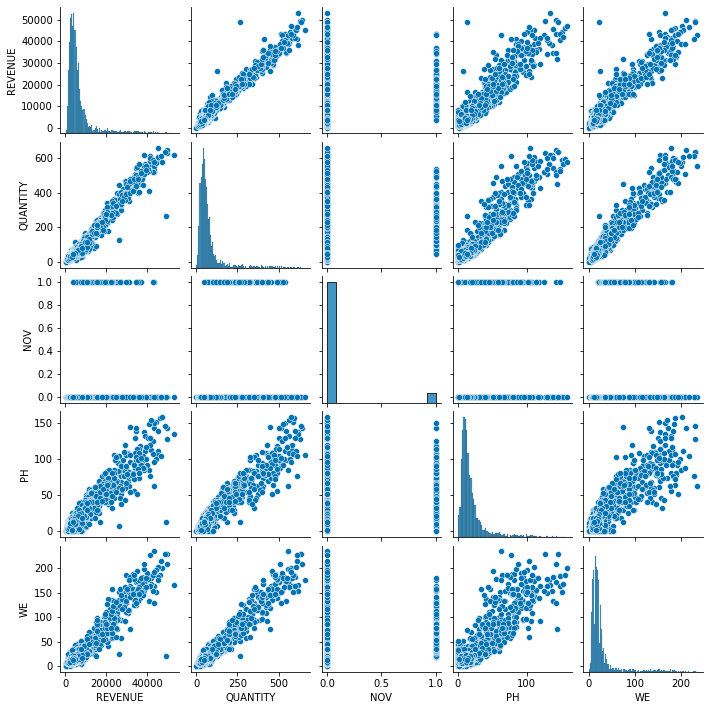

In [8]:
finalmodeldf = modeldf.drop(['ORDER_DATE','CUSTNO'], axis = 1)
sklearnmodeldf = finalmodeldf[['REVENUE','QUANTITY', 'NOV', 'PH', 'WE']]
sns.set_palette('colorblind')
sns.pairplot(data=sklearnmodeldf, height=2)

In [9]:
finalmodeldf.head()

,REVENUE,QUANTITY,NOV,DEC,ML,PH,WE
0,379.65,7,0,0,0.0,0.0,4.0
1,1429.35,13,0,0,0.0,3.0,10.0
2,1314.55,29,0,0,0.0,9.0,8.0
3,2570.80,24,0,0,0.0,7.0,10.0
4,5019.40,70,0,0,0.0,16.0,16.0


In [23]:
## https://practicaldatascience.co.uk/machine-learning/how-to-create-a-linear-regression-model-using-scikit-learn
y = sklearnmodeldf['REVENUE']
##X = sklearnmodeldf[['QUANTITY', 'NOV', 'PH', 'WE']]
X = sklearnmodeldf[['NOV', 'PH','WE']]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Run in statsmodel

In [25]:
import statsmodels.api as sm
X_stats_train = sm.add_constant(X_train)
results = sm.OLS(y_train,X_stats_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                REVENUE   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                 1.101e+04
Date:                Wed, 28 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:17:47   Log-Likelihood:                -17447.
No. Observations:                1970   AIC:                         3.490e+04
Df Residuals:                    1966   BIC:                         3.493e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        350.9293     52.797      6.647      0.000     247.386     454.472
NOV          580.2076    158.986      3.649      0.000     268.409     892.006
PH           143.4988      3.830     37.462      0.000     135.987     151.011
WE           131.9646      2.450     53.873      0.000     127.161     136.769
==============================================================================
Omnibus:                     3253.286   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4930282.400
Skew:                          10.351   Prob(JB):                         0.00
Kurtosis:                     247.204   Cond. No.                         204.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Run Model with SKlearn

In [14]:
## info on scaling: https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [15]:
reg = LinearRegression()
reg.fit(X_scaled_train, y_train)

LinearRegression()

In [16]:
summary = pd.DataFrame (X.columns.values,columns=['Features'])
summary['Weights'] = reg.coef_
summary.loc[-1] = ['INTERCEPT', reg.intercept_]
summary = summary.sort_index()
summary = summary.reset_index(drop=True)
summary

,Features,Weights
0,INTERCEPT,6702.323751
1,NOV,156.214503
2,PH,3004.844205
3,WE,4132.681640


In [17]:
y_pred = reg.predict(X_scaled_test)

#### Check Model's ability to predict

In [18]:
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred))) 
print('')
## reference for mean Absolute Error: https://medium.com/@ewuramaminka/mean-absolute-error-mae-machine-learning-ml-b9b4afc63077
print('Mean Absolute Error ( Base):', metrics.mean_absolute_error(y_test, y_pred))  
print('')
print('Mean Absolute Error (Not collinear):', metrics.mean_absolute_error(y_test, y_pred)) 

RMSE:  1427.3125568775868

Mean Absolute Error ( Base): 928.952037747563

Mean Absolute Error (Not collinear): 928.952037747563


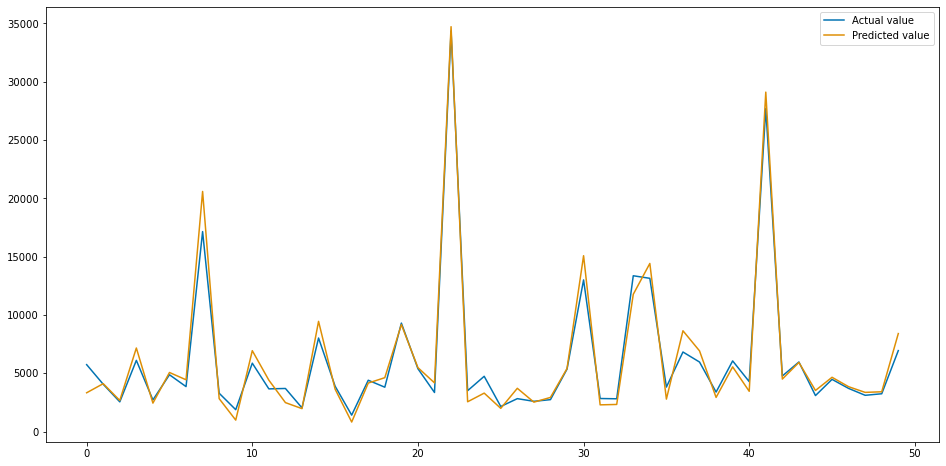

In [19]:
test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual value','Predicted value'])

### Check OLS Assumptions

#### Multicollineatiry

In [35]:
### Variable Inflation Factor Info: https://etav.github.io/python/vif_factor_python.html
from statsmodels.stats.outliers_influence import variance_inflation_factor
x_temp = sm.add_constant(X_train)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif["Features"] = x_temp.columns
print(vif.round(1))

   VIF Factor  Features
0         2.0     const
1        48.8  QUANTITY
2         1.3       NOV
3        12.7        PH
4        22.0        WE
